In [66]:
import pickle
import dill
import random
import pandas as pd 
import seaborn as sns
import numpy as np
import itertools
from collections import Counter
import matplotlib.pyplot as plt 

### First load all the manipulated experiments and pool them together

In [67]:
file_name="metrics.pkl"
experiments_dir="manipulated_experiments"

metrics_manip_path_1=f"results/{experiments_dir}/experiment_1/{file_name}"
metrics_manip_path_2=f"results/{experiments_dir}/experiment_2/{file_name}"
metrics_manip_path_3=f"results/{experiments_dir}/experiment_3/{file_name}"
metrics_manip_path_4=f"results/{experiments_dir}/experiment_4/{file_name}"

with open(metrics_manip_path_1, "rb") as f:
  metrics_manip_1=dill.load(f)
with open(metrics_manip_path_2, "rb") as f:
  metrics_manip_2=dill.load(f)
with open(metrics_manip_path_3, "rb") as f:
  metrics_manip_3=dill.load(f)
with open(metrics_manip_path_4, "rb") as f:
  metrics_manip_4=dill.load(f)

#pool all together but exclude human narratives
metrics_manip=metrics_manip_1+metrics_manip_2+metrics_manip_3+metrics_manip_4
metrics_manip=[metric for metric in metrics_manip if metric.generation_model!="human"]
len(metrics_manip)

48

### Next, define several functions that allow us to count the sign swaps per feature and other conditions

In [68]:
def get_swapped_features(metrics: list, featvaldir: int = +1 , reverse_order: bool= True):

    """This function takes the list metrics and returns dictionaries that contain 
        metrics: list that contains metric objects
        featvaldir: +1 or -1 , whether we restrict ourselves to considering the case where featval < feat average (+1) or opposite (-1)
        reverse_order: bool for if the narratives are manipulated (intended use True)
    Outputs:
        all outsputs are only taken over the features that obey the featvaldir condition (either larger or smaller than avg)

        swapped_feat_1: a dictionary over the datasets with lists that contain all feature names (repeat possible)
                        for which the sign was swapped from POS to NEG by the generation model 
        swapped_feat_2: same as swapped_feat_1 but only to NEG to POS

        all_feats: a dictionary over the datasets with lists that contain all feature names that obeyed the featvaldir 
                   condition regardless of swap

        all_feats_SHAP_pos: same as all_feats except only counting features positive SHAP values

        all_feats_SHAP_neg: same as all_feats except only counting features with negative SHAP values
    """

    swapped_feats_1={"fifa":[],"student":[],"credit":[]}
    swapped_feats_2={"fifa":[],"student":[],"credit":[]}
    all_feats={"fifa":[],"student":[],"credit":[]}   
    all_feats_SHAP_pos={"fifa":[],"student":[],"credit":[]}   
    all_feats_SHAP_neg={"fifa":[],"student":[],"credit":[]}   


    #loop over all metric classes in the list
    for metric in metrics:

        #loop over all narratives i:(0 to 19) and j: the first 4 features in the explanation table for that narrative
        for i,j in itertools.product(range(0,20),range(0,4)):

            #first we get a particular feature name 
            feat_name=metric.explanation_list[i].feature_name.iloc[j] 

            y = lambda x: 1 if x > 0 else -1
            feat_sign= y( metric.explanation_list[i].SHAP_value.iloc[j] )


            #rarely, a feature might be not present in the extraction dict and we ignore these cases:
            try:
                feat_sign_extracted=metric.extractions_dict["gpt-4o"][i][feat_name]["sign"]
            except:
                print("feature not presented in extraction dict for this narrative")
                continue


            #check if the extracted and actual feature sign are the same (which for the manipulated narratives means that the sign was swapped) AND that the feature has a smaller or higher value than the average
            if (feat_sign==feat_sign_extracted) & ((featvaldir*metric.explanation_list[i].feature_value.iloc[j] < featvaldir*metric.explanation_list[i].feature_average.iloc[j] )):
                
                #check two cases whether the SHAP value is pos or neg:
                if (metric.explanation_list[i].SHAP_value.iloc[j]<0):
                    swapped_feats_1[metric.dataset].append(feat_name)

                if (metric.explanation_list[i].SHAP_value.iloc[j]>0):
                    swapped_feats_2[metric.dataset].append(feat_name)
            
            #also add every feature that obeys the featval condition 
            if ((featvaldir*metric.explanation_list[i].feature_value.iloc[j] < featvaldir*metric.explanation_list[i].feature_average.iloc[j] )):
                all_feats[metric.dataset].append(feat_name)
                
            #and count the features that obey the featval condition and also have either only pos or neg shap values:
            if (feat_sign>0) & ((featvaldir*metric.explanation_list[i].feature_value.iloc[j] < featvaldir*metric.explanation_list[i].feature_average.iloc[j] )):
                all_feats_SHAP_pos[metric.dataset].append(feat_name)
            if (feat_sign<0) & ((featvaldir*metric.explanation_list[i].feature_value.iloc[j] < featvaldir*metric.explanation_list[i].feature_average.iloc[j] )):
                all_feats_SHAP_neg[metric.dataset].append(feat_name)


    return swapped_feats_1, swapped_feats_2, all_feats, all_feats_SHAP_pos, all_feats_SHAP_neg

In [69]:
def count_features(swapped_feats_1, swapped_feats_2, all_feats,all_feats_SHAP_pos,all_feats_SHAP_neg, min_tot=0):
    """Given three dictionaries corresponding to the outcomes of the previous function, return dictionaries with feature swap counts"""
    
    counter_1={"fifa":{},"student":{},"credit":{}}
    counter_2={"fifa":{},"student":{},"credit":{}}
    counter_tot={"fifa":{},"student":{},"credit":{}}
    # counter_SHAP_pos={"fifa":{},"student":{},"credit":{}}
    # counter_SHAP_neg={"fifa":{},"student":{},"credit":{}}

    swapped_counts_1={"fifa":{},"student":{},"credit":{}}
    swapped_counts_2={"fifa":{},"student":{},"credit":{}}

    #loop over datasets
    for ds_name in list(swapped_counts_1.keys()):
        
        #count the number of times a feature occurs in respectively the swapped feats and all feats input dicts
        counter_1[ds_name] = Counter(swapped_feats_1[ds_name])
        counter_2[ds_name] = Counter(swapped_feats_2[ds_name])
        counter_tot[ds_name] = Counter(all_feats[ds_name])

        all_feats_SHAP_pos[ds_name]=Counter(all_feats_SHAP_pos[ds_name])
        all_feats_SHAP_neg[ds_name]=Counter(all_feats_SHAP_neg[ds_name])

        #get the names of all features that are contained in the counter results
        swp_feature_names_1=list(counter_1[ds_name].keys())
        swp_feature_names_2=list(counter_2[ds_name].keys())


        #if a feature is present above a min treshold we add the number of swaps it had
        for feat in swp_feature_names_1:
            if counter_tot[ds_name][feat]>=min_tot:
                swapped_counts_1[ds_name][feat]={"swapped count" : counter_1[ds_name][feat]  , "total count": counter_tot[ds_name][feat] } 

        for feat in swp_feature_names_2:
            if counter_tot[ds_name][feat]>=min_tot:
                swapped_counts_2[ds_name][feat]={"swapped count" : counter_2[ds_name][feat]  , "total count": counter_tot[ds_name][feat] } 

        
    return swapped_counts_1, swapped_counts_2, all_feats_SHAP_pos, all_feats_SHAP_neg


def bar_plot(data_1, data_2, fig_title: str):

    #first lets get all the total counts
    names = list(data_1.keys())+list(data_2.keys())
    total_counts = [data_1[name]["total count"] if name in list(data_1.keys()) else data_2[name]["total count"] for name in names]

    sorted_indices = np.argsort(total_counts)[::-1]
    sorted_total_counts = np.array(total_counts)[sorted_indices]
    sorted_names = np.array(names)[sorted_indices]
    names=sorted_names.tolist()
    #now lets sort them by total count size

    #now create the bars in correct order

    counts_1 = [data_1[name]["swapped count"] if name in list(data_1.keys()) else 0 for name in names ]
    counts_2 = [data_2[name]["swapped count"] if name in list(data_2.keys()) else 0 for name in names]

    # Create a bar plot
    fig, ax = plt.subplots(figsize=(10, 6))

    ax.bar(names, sorted_total_counts, color='skyblue', label="Total count")
    ax.bar(names, counts_1, color='orange', label="Swapped count POS to NEG")
    ax.bar(names, counts_2, bottom=counts_1, color='red', label="Swapped count NEG to POS")

    # ax.axhline(y=16, color='red', linestyle='--', linewidth=1, label='1 feat occurence')
    # ax.axhline(y=32, color='green', linestyle='--', linewidth=1, label='2 feat occurences')

    # Add labels and title
    ax.set_xlabel('feature names')
    ax.set_ylabel('Count')
    ax.set_title(fig_title)
    # Show legend
    ax.legend()

    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    return sorted_names, counts_1, counts_2, sorted_total_counts

### Now apply the functions to the data 


In [70]:
#consider the subset of features where featval < avg
FEATVALDIR=+1 

#MINTOT says to filter all features with less than 16 occurences in the pooled metrics -- which is on average equivalent to 1 ocurrence per 20 instances
MINTOT=17

swapped_feats_1, swapped_feats_2, all_feats,all_feats_SHAP_pos,all_feats_SHAP_neg, =get_swapped_features(metrics=metrics_manip, featvaldir=FEATVALDIR, reverse_order= True)
swapped_counts_1, swapped_counts_2,all_feats_SHAP_pos,all_feats_SHAP_neg =count_features(swapped_feats_1, swapped_feats_2, all_feats, all_feats_SHAP_pos,all_feats_SHAP_neg,min_tot=MINTOT)

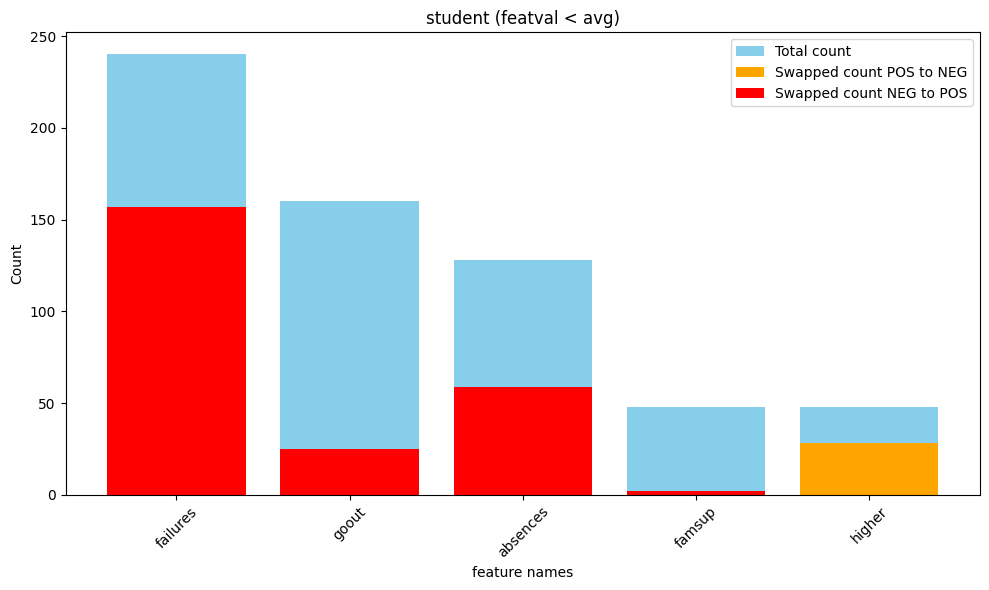

In [71]:
ds_name="student"
sorted_names, counts_1, counts_2, sorted_total_counts=bar_plot(swapped_counts_1[ds_name], swapped_counts_2[ds_name], fig_title=f"{ds_name} (featval < avg)")


In [72]:
for feat_name in swapped_counts_2[ds_name].keys():

    print(feat_name, f"positive SHAP count (original): {all_feats_SHAP_pos[ds_name][feat_name]} ****",f"total featval < avg: {swapped_counts_2[ds_name][feat_name]["total count"]}")

failures positive SHAP count (original): 240 **** total featval < avg: 240
absences positive SHAP count (original): 112 **** total featval < avg: 128
goout positive SHAP count (original): 160 **** total featval < avg: 160
famsup positive SHAP count (original): 48 **** total featval < avg: 48


In [73]:
for feat_name in swapped_counts_1[ds_name].keys():

    print(feat_name, f"neg SHAP count: {all_feats_SHAP_neg[ds_name][feat_name]} ****",f"total featval < avg: {swapped_counts_1[ds_name][feat_name]["total count"]}")

higher neg SHAP count: 48 **** total featval < avg: 48


In [74]:
data = {
    "feat_names": sorted_names,
    "postoneg": counts_1,
    "negtopos": counts_2,
    "total_val": sorted_total_counts
}

df = pd.DataFrame(data)

df.to_csv("results/figures/swapcounts_student_1.csv", index=False)

In [75]:
counts_1

[0, 0, 0, 0, 28]

In [76]:
counts_2

[157, 25, 59, 2, 0]

## NOW FEATVAL > AVG

In [77]:
#consider the subset of features where featval < avg
FEATVALDIR=-1


swapped_feats_1, swapped_feats_2, all_feats,all_feats_SHAP_pos,all_feats_SHAP_neg, =get_swapped_features(metrics=metrics_manip, featvaldir=FEATVALDIR, reverse_order= True)
swapped_counts_1, swapped_counts_2,all_feats_SHAP_pos,all_feats_SHAP_neg =count_features(swapped_feats_1, swapped_feats_2, all_feats, all_feats_SHAP_pos,all_feats_SHAP_neg,min_tot=MINTOT)

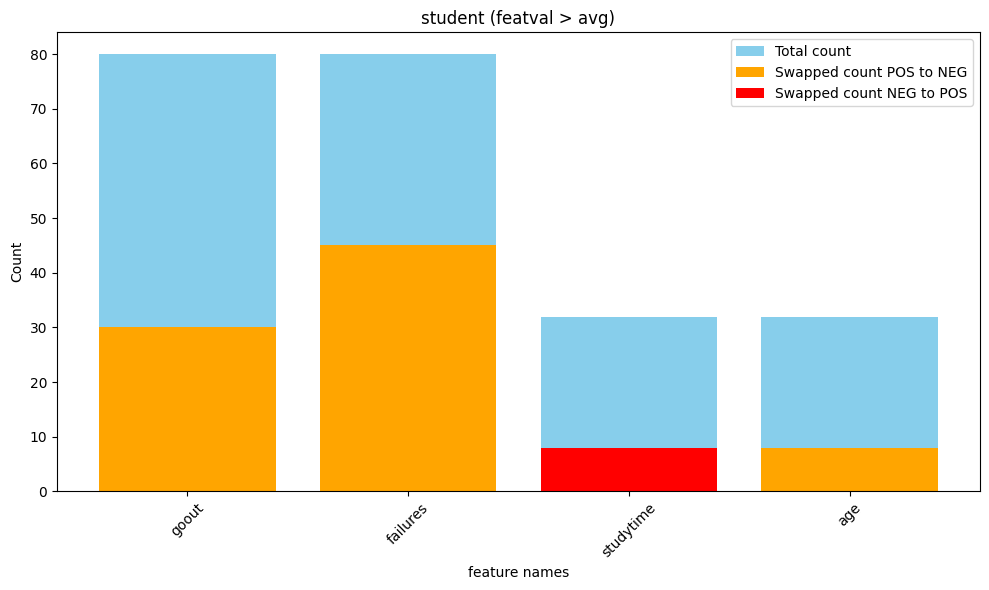

In [78]:
sorted_names, counts_1, counts_2, sorted_total_counts=bar_plot(swapped_counts_1[ds_name], swapped_counts_2[ds_name], fig_title=f"{ds_name} (featval > avg)")

In [79]:
for feat_name in swapped_counts_2[ds_name].keys():

    print(feat_name, f"positive SHAP count (original): {all_feats_SHAP_pos[ds_name][feat_name]} ****",f"total featval > avg: {swapped_counts_2[ds_name][feat_name]["total count"]}")

studytime positive SHAP count (original): 32 **** total featval > avg: 32


In [80]:
for feat_name in swapped_counts_1[ds_name].keys():

    print(feat_name, f"neg SHAP count: {all_feats_SHAP_neg[ds_name][feat_name]} ****",f"total featval > avg: {swapped_counts_1[ds_name][feat_name]["total count"]}")

failures neg SHAP count: 80 **** total featval > avg: 80
goout neg SHAP count: 80 **** total featval > avg: 80
age neg SHAP count: 32 **** total featval > avg: 32


In [81]:
data = {
    "feat_names": sorted_names,
    "postoneg": counts_1,
    "negtopos": counts_2,
    "total_val": sorted_total_counts
}

df = pd.DataFrame(data)

df.to_csv("results/figures/swapcounts_student_2.csv", index=False)